In [2]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# import calculation libraries
from scipy.integrate import odeint
from scipy import integrate, optimize

# time libraries
import datetime
from datetime import datetime

In [4]:
confirmed_US_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv')
deaths_US_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv')
country_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')

country_pop = country_pop.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'})
deaths_US_data = deaths_US_data.rename(columns={'Province/State':'State','Country/Region':'Country'})
confirmed_US_data = confirmed_US_data.rename(columns={'Province/State':'State','Country/Region':'Country'})

In [5]:
confirmed_US_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,112,113,121,121,128,130,133,133,133,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,475,513,573,620,683,725,788,897,903,923
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,42,43,43,45,45,50,51,51,51,51


In [6]:
deaths = deaths_US_data.iloc[:,12:].sum(axis=0)
#deaths = deaths[10:]
confirmed = confirmed_US_data.loc[:,'1/22/20':].sum(axis=0)
#confirmed = confirmed[10:]
confirmed

1/22/20         1
1/23/20         1
1/24/20         2
1/25/20         2
1/26/20         5
            ...  
4/10/20    496530
4/11/20    526391
4/12/20    555304
4/13/20    580223
4/14/20    607213
Length: 84, dtype: int64

In [7]:
def SEIR(y, t, beta, gamma1, gamma2, alpha, d1, r):
    #unpackage paraments
    S, E, I, R, total_death= y
    #S, E, I, R = y

    # calculte curve
    dS_dt = -beta*S*I*r/N 
    dE_dt = beta*S*I*r/N - gamma1*E - alpha*E
    dI_dt = alpha*E - gamma2*I - d1*I
    dR_dt = gamma1*E + gamma2*I

    # the data we want to find
    total_death = d1*E
    #total_confirmed = alpha*E

    # return result
    return([dS_dt, dE_dt, dI_dt, dR_dt, total_death])
    
def fit_odeint(t,beta,gamma1,gamma2,alpha,d1,r):
    re = integrate.odeint(SEIR,[S0,E0,I0,R0,total_death],t,args=(beta,gamma1,gamma2,alpha,d1,r))
    return re[:,-1]

In [8]:
x_data = [i+1 for i in range(len(confirmed))]
y_data = confirmed.values
y_data

array([     1,      1,      2,      2,      5,      5,      5,      5,
            5,      7,      8,      8,     11,     11,     11,     11,
           11,     11,     11,     11,     12,     12,     13,     13,
           13,     13,     13,     13,     13,     13,     15,     15,
           15,     15,     15,     15,     16,     16,     24,     30,
           53,     73,    104,    172,    217,    336,    450,    514,
          708,   1105,   1557,   2147,   2857,   2918,   4307,   6096,
         8873,  14094,  19403,  25725,  33634,  43663,  53736,  65778,
        83836, 101657, 121465, 140909, 161831, 188172, 213362, 243762,
       275582, 308848, 337065, 366660, 396221, 429047, 461432, 496530,
       526391, 555304, 580223, 607213], dtype=int64)

In [9]:
min_I0 = confirmed[0]

In [15]:
country_pop.head()

,Country,Population,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438116346,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377011281,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330578810,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272884327,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219922471,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [22]:
t = [i+1 for i in range(len(confirmed)+17)]

In [40]:
population = country_pop.loc[country_pop['Country']=='United States','Population']
N = population.iloc[0]
min_diff = 9999999
try:
    for E0 in range(10000,20001,200):
        for I0 in range(0,10001,500):
            #E0 = i # inital Exposed          
            S0 = N - I0 - E0 # inital Susceptible

            # other parameters
            R0 = 0 # inital recovered
            total_death = 0
            total_confirmed = I0
        
            y = S0,E0,I0,R0,total_death

            # fitting
            popt, pcov = optimize.curve_fit(fit_odeint, x_data, y_data)
            fitted = fit_odeint(x_data, *popt)

            #calculte diff
            diff = 0
            for i in range(30):
                diff += abs(fitted[-i]-y_data[-i])*(30-i)
                #diff += abs(fitted[-i-1]-y_data[-i-1])

            
            if diff < min_diff:
                min_diff = diff
                re = []
                re = [popt] + [E0] + [I0]
except:
    pass

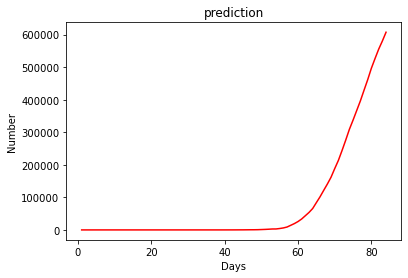

In [47]:
# plot
popt = re[0]
E0 = re[1]
I0 = re[2]
S0 = N - I0 - E0 # inital Susceptible

# other parameters
R0 = 0 # inital recovered
total_death = 0
total_confirmed = I0 


fitted = fit_odeint(x_data, *popt)

plt.plot(x_data, y_data, color = 'r')
plt.plot(x_data, fitted, color = 'b')

#t = [i+1 for i in range(len(deaths)+17)]

#fitted2 = fit_odeint(t, *popt)
#plt.plot(t, fitted2, color = 'yellow')

plt.title("prediction")
plt.ylabel("Number")
plt.xlabel("Days")
plt.show()

In [42]:
# beta, gamma1, gamma2, alpha, d1, r
print (re)

[array([-7.02739510e-01,  1.23457066e-01, -2.12011001e-01, -1.12359316e-01,
        1.06995765e-04,  2.06734873e-02]), 13400, 4000]


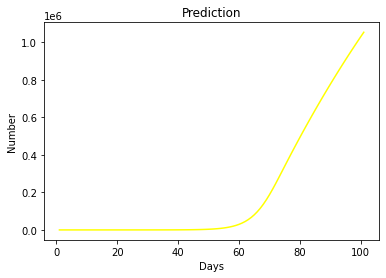

In [43]:
t = [i+1 for i in range(len(deaths)+17)]

fitted2 = fit_odeint(t, *popt)
plt.plot(t, fitted2, color = 'yellow')

plt.title("Prediction")
plt.ylabel("Number")
plt.xlabel("Days")
plt.show()

In [44]:
print(E0,I0)

13400 4000


In [48]:
print(fitted2[-1])

1052644.0472772713


In [49]:
dates = ['4/15/20','4/16/20','4/17/20','4/18/20','4/19/20','4/20/20','4/21/20','4/22/20','4/23/20','4/24/20','4/25/20','4/26/20','4/27/20','4/28/20','4/29/20','4/30/20','5/1/20']

In [50]:
for date in dates:
    deaths[date] = 0

In [51]:
for i in range(len(deaths)):
    deaths[i] = fitted2[i]
deaths.tail()

4/27/20     955757
4/28/20     980383
4/29/20    1004738
4/30/20    1028823
5/1/20     1052644
dtype: int64

In [52]:
result_data = [[x_data, y_data],# actual data
               [x_data, fitted],
               [t, fitted2],
               [popt, E0, I0],
               [deaths]] # prediction data
import pickle
with open('../data/US_comfirmed','wb') as f:
    pickle.dump(result_data,f)

In [53]:
deaths

1/22/20          0
1/23/20          1
1/24/20          2
1/25/20          4
1/26/20          5
            ...   
4/27/20     955757
4/28/20     980383
4/29/20    1004738
4/30/20    1028823
5/1/20     1052644
Length: 101, dtype: int64